In [1]:
import os

# Use the current notebook directory as the root of the project
project_root = os.getcwd()
os.chdir(project_root)

print("Working directory set to:", os.getcwd())

Working directory set to: /Users/zhangjiuyue/jupternotebook/king's project


In [17]:
import pandas as pd
import numpy as np

mcd_df = pd.read_csv("./outputs/mcd_model_comparison_full.csv")
mos_df = pd.read_csv("./outputs/mos_results.csv")  
output_dir = os.path.join("./outputs/")

# 2. 检查关键字段（如Prompt, Model, Sample），必须一致且没有丢失
print(mcd_df.columns)
print(mos_df.columns)

Index(['Prompt', 'Model', 'Sample', 'MCD', 'Human_File', 'AI_File'], dtype='object')
Index(['[Naturalness', '[Stylistic Accuracy', '[Cultural Appropriateness',
       '[Originality', '[Overall Enjoyment', 'Model', 'Prompt'],
      dtype='object')


In [5]:
def calc_sample_idx(i):
    idx = i % 5
    if idx in [0, 2]:
        return 1
    elif idx in [1, 3]:
        return 2
    else:
        return np.nan

mos_df['Prompt'] = [int(i // 5 + 1) for i in range(len(mos_df))]
mos_df['Sample'] = [calc_sample_idx(i) for i in range(len(mos_df))]

mos_df = mos_df.dropna(subset=['Sample'])
mos_df['Sample'] = mos_df['Sample'].astype(int)

In [6]:
# 3. 合并，采用Prompt+Model+Sample三列作为唯一索引
merged_df = pd.merge(mcd_df, mos_df, on=["Prompt", "Model", "Sample"], suffixes=('_mcd', '_mos'))

# 4. 检查结果
print(merged_df.head())

   Prompt   Model  Sample        MCD Human_File   AI_File  [Naturalness  \
0       1  Mureka       1  23.712694      1.mp3     1.mp3          3.30   
1       1  Mureka       2  23.758390      1.mp3  1(1).mp3          3.40   
2       1    Udio       1  23.628310      1.mp3     1.mp3          3.50   
3       1    Udio       2  22.680144      1.mp3  1(1).mp3          3.13   
4       2  Mureka       1  25.871536      2.mp3     2.mp3          3.13   

   [Stylistic Accuracy  [Cultural Appropriateness  [Originality  \
0                 3.43                       3.70          3.10   
1                 2.97                       3.23          3.13   
2                 2.67                       2.73          3.47   
3                 3.17                       3.30          3.17   
4                 3.87                       3.77          3.10   

   [Overall Enjoyment  
0                3.30  
1                3.27  
2                3.37  
3                3.20  
4                3.47  


In [7]:
mos_columns = [col for col in merged_df.columns if col.startswith('[')]
rename_map = {col: col.strip('[').strip() for col in mos_columns}
merged_df.rename(columns=rename_map, inplace=True)

In [22]:
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

import os

for dim in ['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment']:
    rho, pval = spearmanr(merged_df['MCD'], merged_df[dim])
    print(f"{dim}: Spearman r={rho:.2f}, p={pval:.3f}")
    plt.figure(figsize=(6,4))
    sns.scatterplot(data=merged_df, x='MCD', y=dim, hue='Model')
    plt.title(f"MCD vs. MOS ({dim})")
    plt.tight_layout()
    # 动态文件名：用dim.replace空格和小写更通用
    file_name = f"mcd_vs_mos_{dim.lower().replace(' ', '_')}.png"
    plt.savefig(os.path.join(output_dir, file_name), dpi=300)
    plt.close()  # 推荐用close，防止内存泄露

Naturalness: Spearman r=0.24, p=0.304
Stylistic Accuracy: Spearman r=0.24, p=0.303
Cultural Appropriateness: Spearman r=0.38, p=0.096
Originality: Spearman r=-0.19, p=0.416
Overall Enjoyment: Spearman r=0.47, p=0.038


In [9]:
from scipy.stats import spearmanr

dims = ['Naturalness', 'Stylistic Accuracy', 'Cultural Appropriateness', 'Originality', 'Overall Enjoyment']
result_list = []

for prompt in sorted(merged_df['Prompt'].unique()):
    for model in ['Mureka', 'Udio']:
        subset = merged_df[(merged_df['Prompt'] == prompt) & (merged_df['Model'] == model)]
        for dim in dims:
            if len(subset) > 1:  # 至少两首歌
                rho, pval = spearmanr(subset['MCD'], subset[dim])
                result_list.append({
                    'Prompt': prompt,
                    'Model': model,
                    'Dimension': dim,
                    'Spearman_r': rho,
                    'p_value': pval
                })

result_df = pd.DataFrame(result_list)
print(result_df)

    Prompt   Model                 Dimension  Spearman_r  p_value
0        1  Mureka               Naturalness         1.0      NaN
1        1  Mureka        Stylistic Accuracy        -1.0      NaN
2        1  Mureka  Cultural Appropriateness        -1.0      NaN
3        1  Mureka               Originality         1.0      NaN
4        1  Mureka         Overall Enjoyment        -1.0      NaN
5        1    Udio               Naturalness         1.0      NaN
6        1    Udio        Stylistic Accuracy        -1.0      NaN
7        1    Udio  Cultural Appropriateness        -1.0      NaN
8        1    Udio               Originality         1.0      NaN
9        1    Udio         Overall Enjoyment         1.0      NaN
10       2  Mureka               Naturalness        -1.0      NaN
11       2  Mureka        Stylistic Accuracy         1.0      NaN
12       2  Mureka  Cultural Appropriateness        -1.0      NaN
13       2  Mureka               Originality        -1.0      NaN
14       2

/Users/zhangjiuyue/Anaconda/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [10]:
# 找每个Prompt下最高和最低的相关性
for prompt in sorted(merged_df['Prompt'].unique()):
    dfp = result_df[result_df['Prompt'] == prompt]
    print(f"\nPrompt {prompt}:")
    print(dfp.pivot(index='Model', columns='Dimension', values='Spearman_r').round(2))


Prompt 1:
Dimension  Cultural Appropriateness  Naturalness  Originality  \
Model                                                           
Mureka                         -1.0          1.0          1.0   
Udio                           -1.0          1.0          1.0   

Dimension  Overall Enjoyment  Stylistic Accuracy  
Model                                             
Mureka                  -1.0                -1.0  
Udio                     1.0                -1.0  

Prompt 2:
Dimension  Cultural Appropriateness  Naturalness  Originality  \
Model                                                           
Mureka                         -1.0         -1.0         -1.0   
Udio                            NaN          NaN         -1.0   

Dimension  Overall Enjoyment  Stylistic Accuracy  
Model                                             
Mureka                   1.0                 1.0  
Udio                    -1.0                -1.0  

Prompt 3:
Dimension  Cultural Appropriateness  

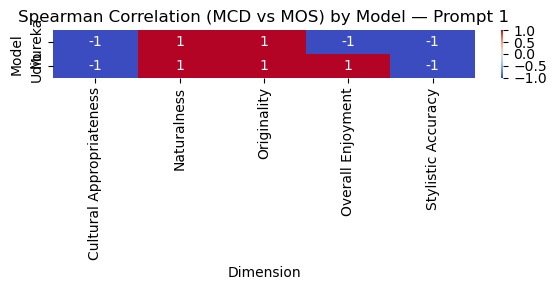

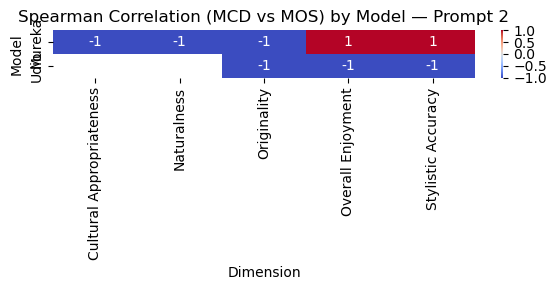

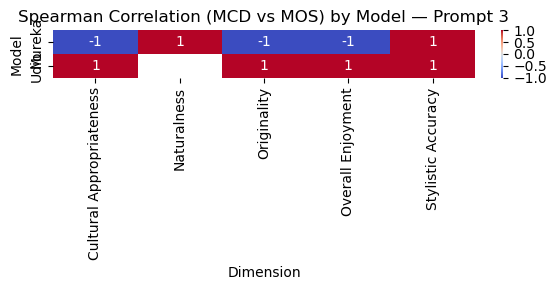

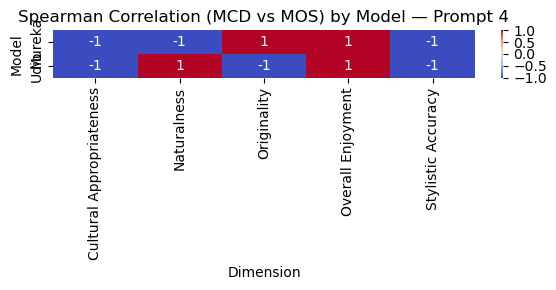

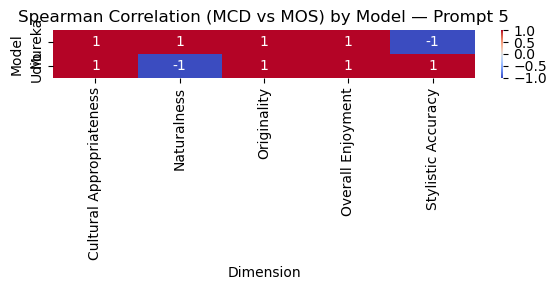

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

for prompt in sorted(merged_df['Prompt'].unique()):
    plt.figure(figsize=(6,3))
    pivoted = result_df[result_df['Prompt'] == prompt].pivot(index='Model', columns='Dimension', values='Spearman_r')
    sns.heatmap(pivoted, annot=True, cmap='coolwarm', center=0)
    plt.title(f'Spearman Correlation (MCD vs MOS) by Model — Prompt {prompt}')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f'corr_heatmap_prompt{prompt}.png'), dpi=300)
    plt.show()